In [1]:
import numpy
import qubit_matmul
import scipy.sparse
from matplotlib import pyplot
import os
import shadow_reconstruction

# Make XXZ model

In [3]:
splus = numpy.array([
    [0.0, 0.0],
    [1.0, 0.0]
])
sminus = numpy.array([
    [0.0, 1.0],
    [0.0, 0.0]
])
sz = numpy.array([
    [-1.0, 0.0],
    [0.0, 1.0]
])

spm = numpy.kron(splus, sminus)
smp = numpy.kron(sminus, splus)
szz = numpy.kron(sz,sz)
szi = numpy.kron(sz,numpy.eye(2))
siz = numpy.kron(numpy.eye(2),sz)

def make_xxz_ham(l,jz,hz=0.0):
    terms = []
    
    interaction = -(spm + smp) + jz*szz
    hz = sz * hz
    
    for i in range(l):
        a = i
        b = (i+1)%l
        
        terms.append(qubit_matmul.TensorMatf64([a, b], interaction.flatten()))
        terms.append(qubit_matmul.TensorMatf64([i], hz.flatten()))
        
    acc = terms[0]
    for t in terms[1:]:
        acc = acc + t
    return acc

def make_z(i):
    return qubit_matmul.TensorMatf64([i], sz.flatten())

def make_zz(i,j):
    return qubit_matmul.TensorMatf64([i,j], szz.flatten())

def make_pm(i,j):
    return qubit_matmul.TensorMatf64([i, j], spm.flatten())

def make_pmpm(i,j,k,l):
    return qubit_matmul.TensorMatf64([i, j,k,l], numpy.kron(spm,spm).flatten())

# Corr

In [4]:
def make_data(l, j, r, nsamples=10_000):
    ham = make_xxz_ham(l,j)
    ham = ham.get_sparse(l)
    vals, vecs = scipy.sparse.linalg.eigsh(ham,k=1)
    gs = vecs[:,0]
    
    # Check half filling
    data = []
    for i,x in enumerate(gs):
        if abs(x) > 1e-10:
            data.append(bin(i)[2:].zfill(l).count('1'))
    assert(all(map(lambda x: x==l//2, data)))
    
    corr_check = make_pm(0,r).get_sparse(l)
    ground_truth = gs @ (corr_check @ gs)
    
    rho = shadow_reconstruction.DensityMatrix.new_pure_dense(gs.astype(numpy.complex128))
    exp = shadow_reconstruction.Experiment(l)
    samples = exp.sample(rho, nsamples)
    recon = shadow_reconstruction.Reconstruction()

    ests = []
    for i in range(l):
        string = ['I'] * l
        string[i] = '+'
        string[(i+r)%l] = '-'
        string = ''.join(string)
        ests.append(recon.estimate_string(string, samples))
    return numpy.array(ests), ground_truth

In [22]:
ntrials = 128
nsamples = 1_000
ls = [6,8,10,12]
errs = {}

for l in ls:
    nsamples = int(nsamples)
    errs[l] = []
    for _ in range(ntrials):
        ests, ground_truth = make_data(l,1.0,1,nsamples=nsamples)
        errs[l].append(abs(ests.mean() - ground_truth))

In [23]:
ls = numpy.array(ls)
errs = {
    k: numpy.array(v) for k,v in errs.items()
}

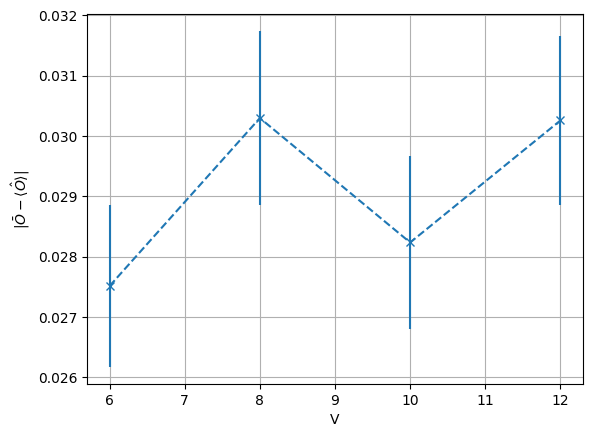

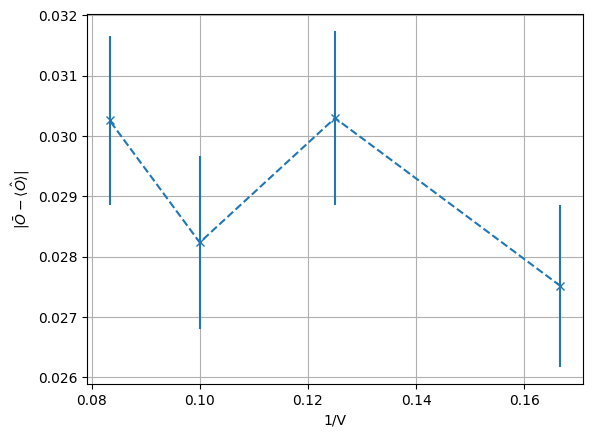

In [26]:
xvals = ls
yvals = numpy.array([(errs[l]).mean() for l in ls])
ystds = numpy.array([(errs[l]).std()/(ntrials**(0.5)) for l in ls])

pyplot.errorbar(xvals, yvals, yerr=ystds, fmt='x--')
pyplot.grid()
pyplot.xlabel('V')
pyplot.ylabel(r'$|\bar{O} - \langle \hat{O} \rangle|$')
pyplot.savefig('error_scale.pdf')
pyplot.show()

pyplot.errorbar(1/xvals, yvals, yerr=ystds, fmt='x--')
pyplot.grid()
pyplot.xlabel('1/V')
pyplot.ylabel(r'$|\bar{O} - \langle \hat{O} \rangle|$')
pyplot.show()